In [1]:
import splat
import wisps
import numpy as np
import matplotlib.pyplot as plt
from wisps import Annotator as an
from wisps import datasets
%matplotlib inline

In [2]:
spex= an.reformat_table(wisps.datasets['spex'])
data=an.reformat_table(wisps.datasets['stars'])

data['spt']=data.spt.apply(wisps.make_spt_number)
spex['spt']=spex.spt.apply(wisps.make_spt_number)

data=data[data.snr1>3.]

Create a training set, a test set and a set to predict for 

In [3]:
features=wisps.INDEX_NAMES

Inspect the features, I know these features (at leasr spectral indices) are correlated but also have high variance, I could pick my favorite features and use those instead 

In [4]:
#remove infinities and nans
def remove_infinities_and_nans(array):
    array=np.log10(array)
    infinbools=np.isinf(array)
    nanbools=np.isnan(array)
    mask=np.logical_or(infinbools, nanbools)
    array[mask]=-99
    return array

In [5]:
spex[features]=spex[features].apply(remove_infinities_and_nans, axis=0)
data[features]=data[features].apply(remove_infinities_and_nans, axis=0)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(spex[features].values)
spex_pcaed=pca.transform(spex[features].values)
proj_sample=pca.transform(data[features].values)

In [7]:
colors=an.color_from_spts(spex.spt.values, cmap='viridis')

(-1.0, 1.0)

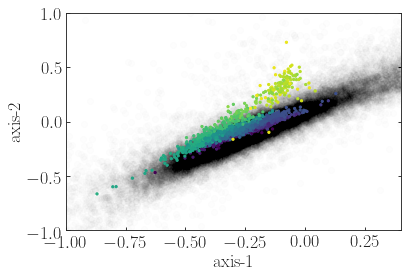

In [8]:
fig, ax=plt.subplots()
plt.scatter(proj_sample[:,0], proj_sample[:,1], alpha=0.006, color='k')
plt.scatter(spex_pcaed[:,0],spex_pcaed[:, 1], color=colors, s=5.)

plt.xlabel('axis-1', fontsize=18)
plt.ylabel('axis-2', fontsize=18)

#ax.set_yscale('log')
#ax.set_xscale('log')
plt.xlim([-1., .4])
plt.ylim([-1., 1.])

In [9]:
import pandas as pd

In [10]:
train_df=spex
train_df['axis1']=spex_pcaed[:,0]
train_df['axis2']=spex_pcaed[:,1]
train_df['spt']=spex.spt

In [11]:
pred_df=data
pred_df['axis1']=proj_sample[:,0]
pred_df['axis2']=proj_sample[:,1]
pred_df['spt']=data.spt

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score

In [13]:

def add_labels(spt):
    label=0.0
    if 17<=spt<20:
        label=1.0
    if 20<=spt<30:
        label=2.0
    if  30<=spt<39.:
        label=3.0
    return label



def compute_accuracy_score(features=features, split_size=0.5):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    #train_set=train_df[features]
    X_train, X_test, y_train, y_test = train_test_split(train_df[features].values, train_df['label'].values, test_size=split_size, 
                                                        random_state=123456) ###grammar  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf = RandomForestClassifier( oob_score=True, verbose=0.)
    rf.fit(X_train, y_train)
    
    pred_labels = rf.predict(X_test)
    model_accuracy = accuracy_score(y_test, pred_labels)
    
    #pred_probs=rf.predict_proba(X_test)
    #decispth=rf.decision_path(X_test)
    
    return model_accuracy, rf, scaler

In [14]:
rf_features=['axis1', 'axis2', 'snr1', 'snr2', 'f_test','line_chi', 'spex_chi']

In [15]:
train_df['label']=train_df.spt.apply(add_labels)
pred_df['label']=pred_df.spt.apply(add_labels)

In [16]:
train_df[rf_features]=train_df[rf_features].apply(remove_infinities_and_nans, axis=0)
pred_df[rf_features]=pred_df[rf_features].apply(remove_infinities_and_nans, axis=0)

In [17]:
acc, model, scaler=compute_accuracy_score(features=rf_features, split_size=0.5)

In [18]:
#apply model
pred_set=scaler.transform(pred_df[rf_features].values)
pred_labels=model.predict(pred_set)

(array([56205.,     0.,     0.,  6988.,     0.,     0.,  2314.,     0.,
            0.,  1245.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

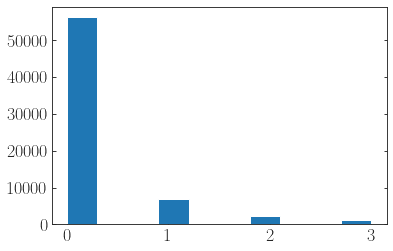

In [19]:
plt.hist(pred_labels)

In [20]:
len(pred_labels>0)

66752

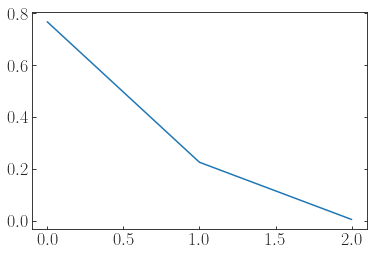

In [30]:
plt.plot(pca.explained_variance_ratio_)